# Classification Game

# What is a convolution? 

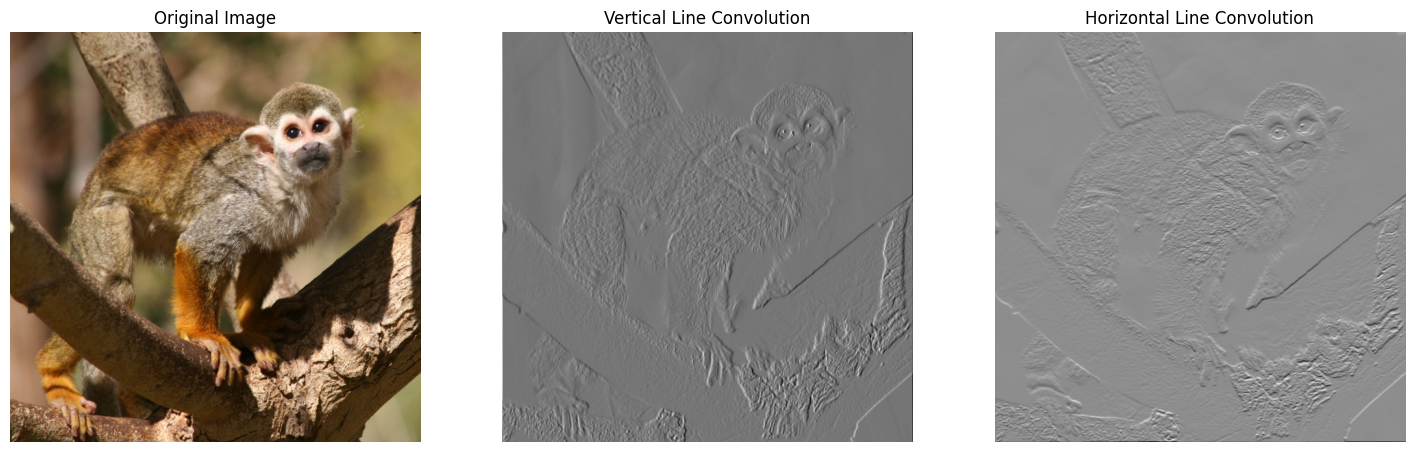

In [1]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Load the image
image_path = 'Monkey/training/training/n7/n7023.jpg'
image = Image.open(image_path).convert("RGB")

# Transform the image to a tensor
transform = transforms.ToTensor()
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Define a vertical line kernel
# Define a vertical line kernel
# Define vertical and horizontal line detection kernels
vertical_line_kernel = torch.tensor([[-1.0, 0.0, 1.0],
                                     [-1.0, 0.0, 1.0],
                                     [-1.0, 0.0, 1.0]], dtype=torch.float32)

horizontal_line_kernel = torch.tensor([[-1.0, -1.0, -1.0],
                                       [0.0,  0.0,  0.0],
                                       [1.0,  1.0,  1.0]], dtype=torch.float32)

# Expand kernels to match RGB channels
vertical_line_kernel = vertical_line_kernel.expand(1, 3, 3, 3)
horizontal_line_kernel = horizontal_line_kernel.expand(1, 3, 3, 3)

# Apply the vertical and horizontal kernels to each channel
vertical_convolved = F.conv2d(image_tensor, vertical_line_kernel, padding=1)
horizontal_convolved = F.conv2d(image_tensor, horizontal_line_kernel, padding=1)


# Convolve the image with the vertical line kernel

# Remove the batch dimension and convert to a NumPy array for visualization
vertical_convolved = vertical_convolved.squeeze().detach().numpy()
horizontal_convolved = horizontal_convolved.squeeze().detach().numpy()
# Plot the original and convolved images side by side
# Plot the original image, vertical lines, and horizontal lines
plt.figure(figsize=(18, 6))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Vertical line convolution
plt.subplot(1, 3, 2)
plt.imshow(vertical_convolved, cmap="gray")
plt.title("Vertical Line Convolution")
plt.axis("off")

# Horizontal line convolution
plt.subplot(1, 3, 3)
plt.imshow(horizontal_convolved, cmap="gray")
plt.title("Horizontal Line Convolution")
plt.axis("off")

plt.show()

# Dataset. 
### You will use a monkey dataset consisting of ca 1000 images of monkey. The goal is to be able to classify them.
### There are ten monkey classes


1097
767


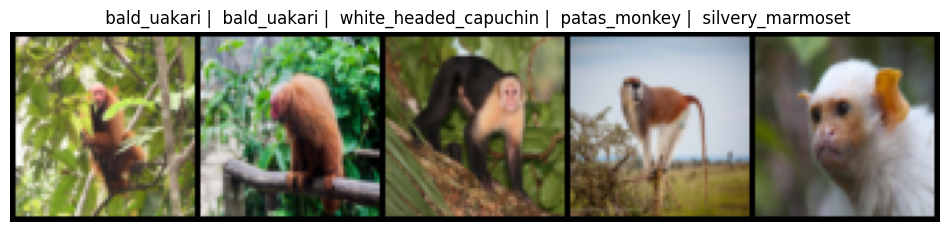

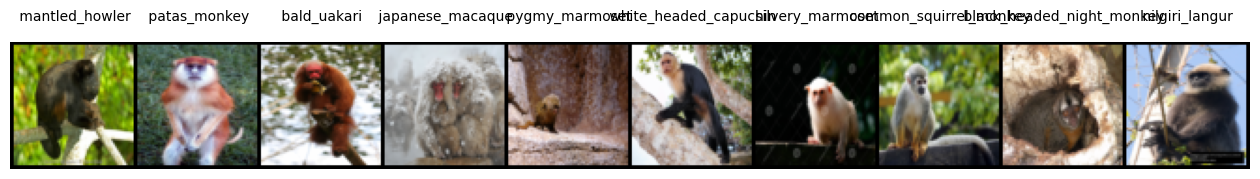

In [1]:
from torchvision import transforms, utils
from Dataset import CustomImageDataset, MonkeyImageDataset

NUM_OF_CLASSES = 10
IMAGE_SIZE = (64, 64)
DATA_PERCENTAGE = 0.7
transform = transforms.Compose([
   # Randomly flip the images vertically
    #transforms.RandomVerticalFlip(p=0.2),  # Randomly flip the image vertically with 20% probability
    #transforms.RandomHorizontalFlip(p=0.2),  # Randomly flip the image horizontally with 20% probability
    #transforms.RandomRotation(degrees=15),  # Rotate the image randomly within a 15-degree range
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly change brightness, contrast, etc.
    transforms.ToTensor(),
    transforms.Resize((IMAGE_SIZE[0], IMAGE_SIZE[1])), 

    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
#dataset = CustomImageDataset('Monkey/training/training', transform=transform, amount_of_classes=NUM_OF_CLASSES, data_percentage=0.3)
dataset = MonkeyImageDataset('Monkey/training/training', transform, NUM_OF_CLASSES, data_percentage = DATA_PERCENTAGE )
dataset.visualize(5)


dataset.visualize_all_classes()


# Let's define our model! 
### Lets build a Convolutional Neural Network (CNN). It uses convolutions (one can think of it as filters)

In [2]:
#define model

import torch.nn as nn
import torch.nn.functional as F
import torch

class ClassificationModel(nn.Module):
    def __init__(self, num_classes=10, input_size=(500, 500)):
        super(ClassificationModel, self).__init__()
        
        # First convolutional layer: 3 input channels (RGB), 32 output channels, kernel size 5, padding 2 to preserve size
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        
        # Second convolutional layer: outputs a 32-channel feature map
        #self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        
        ## Third convolutional layer: further reduces spatial dimensions
        #self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=2)


        # Calculate the size of the fully connected layer dynamically
        self.fc_input_size = self._get_fc_input_size(input_size)
        self.fc1 = nn.Linear(self.fc_input_size, 64)  # Adjusted for the final size after pooling
        
        # Prediction layer
        self.prediction = nn.Linear(64, num_classes)
        
    def _get_fc_input_size(self, input_size):
        x = torch.zeros(1, 3, *input_size)  # Create a dummy input tensor
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        #x = F.relu(self.conv2(x))
        #x = F.max_pool2d(x, kernel_size=2)
        #x = F.relu(self.conv3(x))
        #x = F.max_pool2d(x, kernel_size=2)
        return x.numel()  # Total number of elements after conv layers
    
    def forward(self, x):
        # First conv -> ReLU -> Max Pooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Second conv -> ReLU -> Max Pooling
        #x = F.relu(self.conv2(x))
        #x = F.max_pool2d(x, kernel_size=2)

        # Third conv -> ReLU -> Max Pooling
        #x = F.relu(self.conv3(x))
        #x = F.max_pool2d(x, kernel_size=2)


        # Flatten the tensor for fully connected layer
        x = x.view(x.size(0), -1)  # Output: (batch_size, 128 * 16 * 16) for 500x500 input

        # Fully connected layer -> ReLU
        x = F.relu(self.fc1(x))

        # Output layer (no activation, to be combined with a loss function later)
        x = self.prediction(x)
        # Optionally remove Softmax from here
        return x
    



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]           2,432
            Linear-2                   [-1, 64]       2,097,216
            Linear-3                   [-1, 10]             650
Total params: 2,100,298
Trainable params: 2,100,298
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 1.00
Params size (MB): 8.01
Estimated Total Size (MB): 9.06
----------------------------------------------------------------


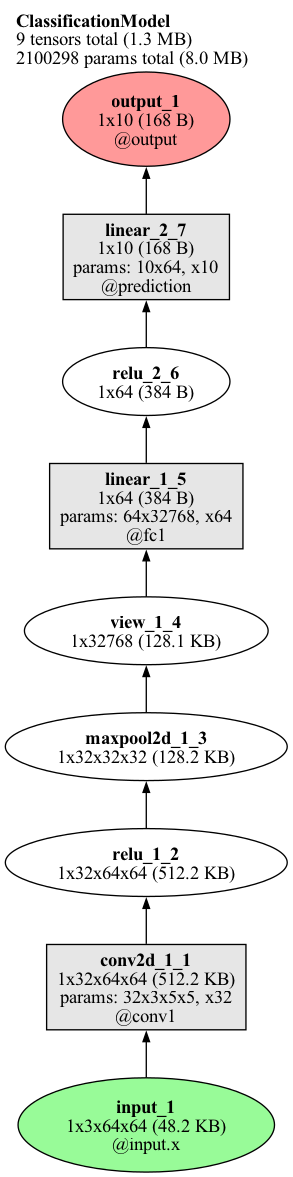

In [3]:
from torchsummary import summary
import torchlens as tl
import graphviz
from IPython.display import Image

graphviz.set_jupyter_format('png')


model = ClassificationModel(num_classes=NUM_OF_CLASSES, input_size=IMAGE_SIZE)

summary(model, (3, IMAGE_SIZE[0], IMAGE_SIZE[1]))
x = torch.rand(1, 3, IMAGE_SIZE[0], IMAGE_SIZE[1])

model_hist = tl.log_forward_pass(model,x, vis_opt='unrolled')
#model_graph.visual_graph

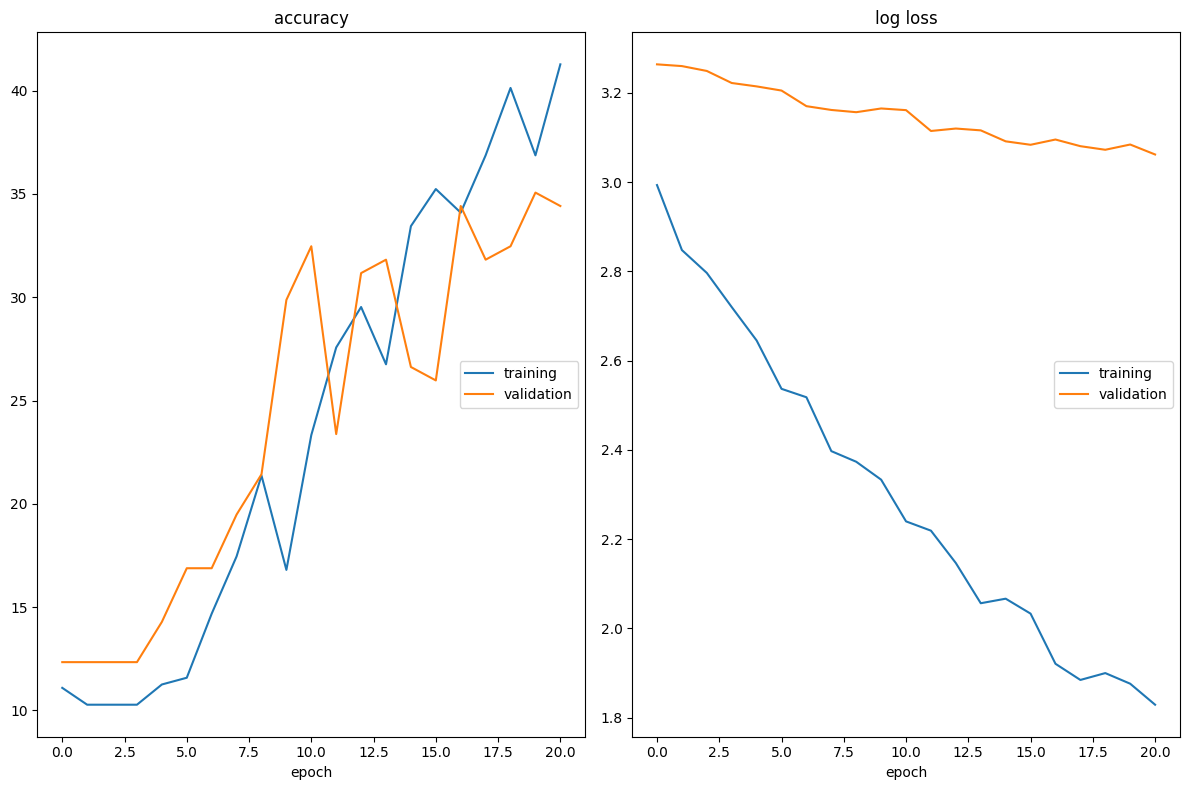

accuracy
	training         	 (min:   10.277, max:   41.272, cur:   41.272)
	validation       	 (min:   12.338, max:   35.065, cur:   34.416)
log loss
	training         	 (min:    1.829, max:    2.994, cur:    1.829)
	validation       	 (min:    3.062, max:    3.264, cur:    3.062)
Training Finished!
272
272
images:  272


/Users/isakknutsson/Desktop/Classification-Game/test_model.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, requires_grad=False)


[' mantled_howler', ' patas_monkey', ' bald_uakari', ' japanese_macaque', ' pygmy_marmoset', ' white_headed_capuchin', ' silvery_marmoset', ' common_squirrel_monkey', ' black_headed_night_monkey', ' nilgiri_langur']


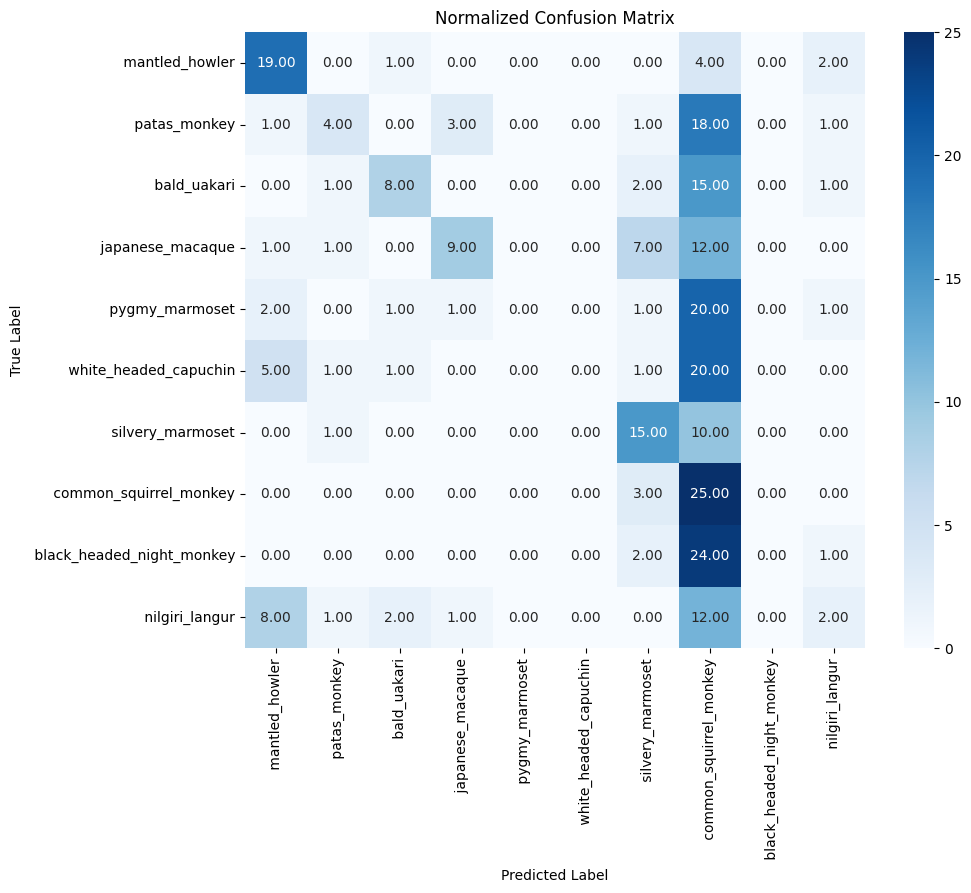

Accuracy of the network on the test images: 30 %


In [11]:
from train import train, training_info
from test_model import test
import torch.optim
from torch.utils.data import DataLoader, random_split
import torch.nn as nn

device = 'mps'

START_EPOCH = 0
EPOCHS = 20 # how long should the model train
MODEL_NAME = "2 Conv wheightd 0.01"
ID = 2213
LR = 0.00005 # how "much" should the model learn
BATCH_SIZE = 32# how many images should the model see before updating

model_info = {
            'epochs' : EPOCHS,
            'batch_size' : BATCH_SIZE,
            'lr' : LR,
            'ID' : ID,
            'model_name' : MODEL_NAME

}

dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)  # 80% for training
val_size = dataset_size - train_size   # 20% for validation

class_weights = torch.ones(NUM_OF_CLASSES)
class_weights[7] = 5
class_weights = class_weights.to(device)
if NUM_OF_CLASSES > 2:
    criterion = nn.CrossEntropyLoss(weight=class_weights)
else:
    criterion = nn.BCELoss()


print(train_size, val_size)

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for training and validation sets
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize the models
model1 = ClassificationModel(num_classes=NUM_OF_CLASSES, input_size=IMAGE_SIZE)


# Create optimizers for the model. This will try to find the optimal parameters in the model
optimizer1 = torch.optim.Adam(model1.parameters(), lr=LR)

# Move models to gpu and train 
model1.to(device)
model1, t_loss, t_acc, v_loss, v_acc = train(model1, train_loader, val_loader, optimizer1, criterion, device, start_epoch=START_EPOCH, num_epochs=EPOCHS, model_name=MODEL_NAME, unique_id=ID)

test_dataset = MonkeyImageDataset('Monkey/validation/validation', transform, NUM_OF_CLASSES, 1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

# Test the model
acc = test(model=model1, testloader=test_loader, device=device, model_name=MODEL_NAME, unique_id=ID)

model_info['t_loss'] = t_loss
model_info['t_acc'] = t_acc

model_info['v_loss'] = v_loss
model_info['v_acc'] = v_acc

training_info(model_info=model_info)

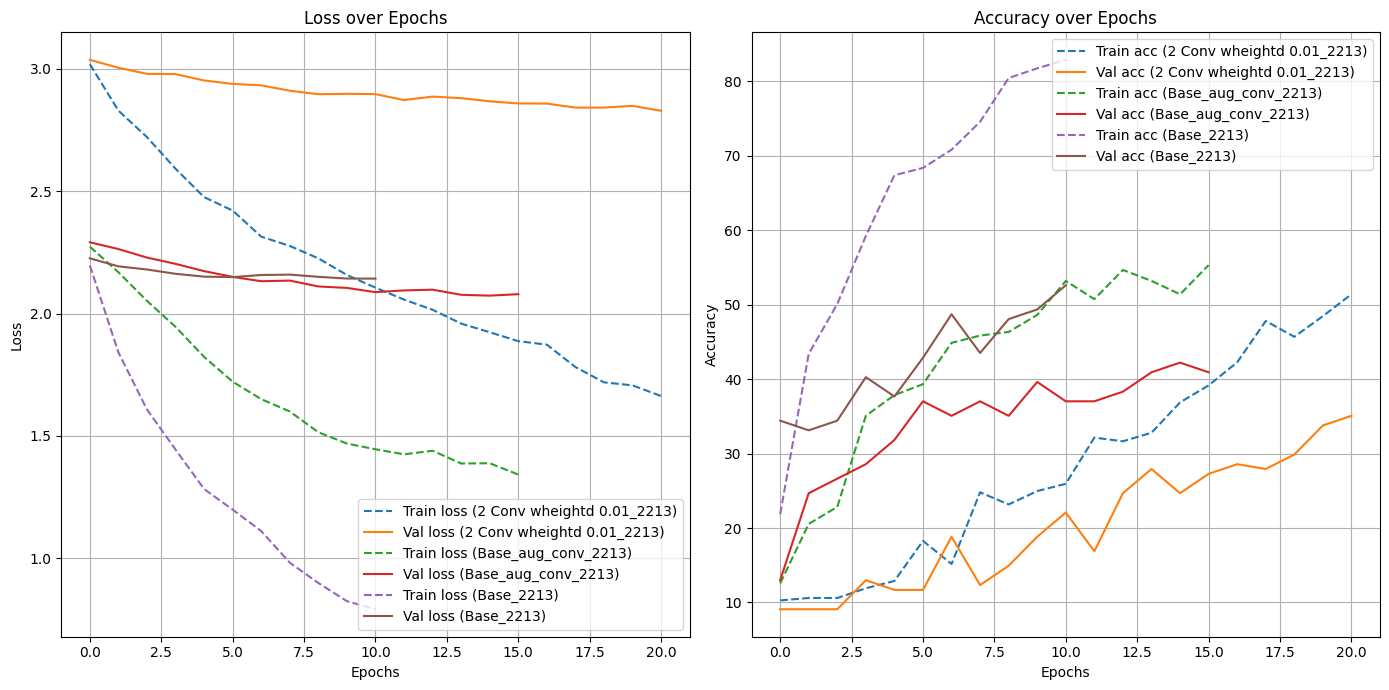

+----------+--------------+-------+------+----------------------+---------------------------+
|   epochs |   batch_size |    lr |   ID | model_name           | Model Name                |
|----------+--------------+-------+------+----------------------+---------------------------|
|       20 |           32 | 5e-05 | 2213 | 2 Conv wheightd 0.01 | 2 Conv wheightd 0.01_2213 |
|       15 |           32 | 5e-05 | 2213 | Base_aug_conv        | Base_aug_conv_2213        |
|       10 |           32 | 5e-05 | 2213 | Base                 | Base_2213                 |
+----------+--------------+-------+------+----------------------+---------------------------+


In [12]:
import matplotlib.pyplot as plt
from train import plot_experiments

plot_experiments('training_metrics')